In this project we will build and encoder-decoder model with Luong attention that will translate French sentences to English.

The dataset used in this notebook is provided by: [http://www.manythings.org/anki/](http://www.manythings.org/anki/).

This dataset contains approximatly 180 000 tab-delimited English-French sentence pairs.

# Import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

import unicodedata
import re
import os
import io

np.random.seed(42)
tf.random.set_seed(42)

path_to_file = '../input/bilingual-sentence-pairs/fra.txt'

# If the notebook is running in colab the above file doesn't exist
if not os.path.exists(path_to_file):
    # if you are running this notebook in colab please download the file from 
    # the link above and put it in the current directory
    path_to_file = os.path.join(os.curdir, 'fra.txt')

# Download and preprocess the data

In [2]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

def preprocess(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s)
    s = s.strip()
    # adding start-of-sequence (sos) token and end-of-sequence (eos) token
    s = '<sos> ' + s + ' <eos>'
    return s

In [3]:
def tokenize(language):
    # Use <unk> token for unkown words
    tokenizer = Tokenizer(filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(language)

    tensor = tokenizer.texts_to_sequences(language)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, tokenizer

def load_dataset(path, num_examples=None, prints=False) :
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    # list containing word pairs in the format: [[ENGLISH], [FRENCH]]
    word_pairs = [[preprocess(w) for w in l.split('\t')[:-1]] for l in lines[:num_examples]]
    targ_lang, input_lang = zip(*word_pairs)

    if prints:
        print(targ_lang[-1])
        print(input_lang[-1])
        return
    
    input_tensor, input_tokenizer = tokenize(input_lang)
    targ_tensor, targ_tokenizer = tokenize(targ_lang)

    return input_tensor, targ_tensor, input_tokenizer, targ_tokenizer

load_dataset(path_to_file, num_examples=1000, prints=True)

<sos> i need it . <eos>
<sos> j en ai besoin . <eos>


# Load and Split de Data

In [4]:
inp_tensor, targ_tensor, inp_lang, targ_lang = load_dataset(path_to_file)
inp_tensor_train, inp_tensor_val, \
targ_tensor_train, targ_tensor_val = \
train_test_split(inp_tensor, targ_tensor, test_size=0.2)
print("Input tensors: ", inp_tensor_train.shape, inp_tensor_val.shape)
print("Target tensors: ", targ_tensor_train.shape, targ_tensor_val.shape)

Input tensors:  (148466, 65) (37117, 65)
Target tensors:  (148466, 53) (37117, 53)


# Create the Dataset

In [5]:
buffer_size = len(inp_tensor_train)
batch_size = 64
steps_per_epoch = len(inp_tensor_train) // batch_size
embedding_dim = 256
units = 1024 
vocab_inp_size = len(inp_lang.index_word) + 1
vocab_targ_size = len(targ_lang.index_word) + 1

def create_dataset(shuffle=True, buffer_size=buffer_size, batch_size=batch_size):
    ds = tf.data.Dataset.from_tensor_slices((inp_tensor_train, targ_tensor_train))
    if shuffle:
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds.prefetch(1)

train_dataset = create_dataset()
valid_dataset = create_dataset(shuffle=False)
inp_batch, targ_batch = next(iter(train_dataset))
inp_batch.shape, targ_batch.shape

(TensorShape([64, 65]), TensorShape([64, 53]))

# Create the Model

The model will be similar to the TensorFlow tutorial except that I will use Luong attention instead of Bahdanau and LSTM layer instead of GRU.

In [6]:
from tensorflow.keras.layers import Embedding, LSTM, dot, Dense

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True)

    def call(self, inp_batch, state_h, state_c):
        inp_batch = self.embedding(inp_batch)
        output, state_h, statec = self.lstm(inp_batch, initial_state=[state_h, state_c])
        return output, state_h, state_c

    def initialize_state(self):
        return [tf.zeros((self.batch_size, self.enc_units)), tf.zeros((self.batch_size, self.enc_units))]

encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)
[enc_state_h, enc_state_c] = encoder.initialize_state()
enc_output, enc_state_h, enc_state_c = encoder(inp_batch, enc_state_h, enc_state_c)
print (f'encoder output:       (batch size, seq length, enc_units)  {enc_output.shape}')
print (f'encoder hidden state h: (batch size, enc_units)            {enc_state_h.shape}')
print (f'encoder hidden state c: (batch size, enc_units)            {enc_state_c.shape}')

encoder output:       (batch size, seq length, enc_units)  (64, 65, 1024)
encoder hidden state h: (batch size, enc_units)            (64, 1024)
encoder hidden state c: (batch size, enc_units)            (64, 1024)


In [7]:
def print_shapes(enc_output, dec_state, score, attention_weights, context_vector):
    print(f"btach_size: {batch_size}")
    print(f"seq_length: {inp_tensor_train.shape[1]}")
    print(f"enc_units: {units}")
    print()
    print(f"enc_output:        {enc_output.shape}")
    print(f"dec_state:         {dec_state.shape}")
    print(f"score:             {score.shape}")
    print(f"attention_weights: {attention_weights.shape}")
    print(f"context_vector:    {context_vector.shape}")

In [8]:
class LuongAttention(tf.keras.layers.Layer):
    def __init(self):
        super().__init__()

    def call(self, dec_state_h, dec_state_c, enc_output, prints=False):
        dec_state = tf.add(dec_state_h, dec_state_c)
        dec_state = dec_state[:, :, tf.newaxis]
    
        score = dot([enc_output, dec_state], axes=[2, 1])
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        if prints:
            print_shapes(enc_output, dec_state, score, attention_weights, context_vector)
            return
        return context_vector, attention_weights

attention_layer = LuongAttention()
# at the beginning we set the decoder state to the encoder state
dec_state_h, dec_state_c = enc_state_h, enc_state_c
attention_layer(dec_state_h, dec_state_c, enc_output, prints=True)

btach_size: 64
seq_length: 65
enc_units: 1024

enc_output:        (64, 65, 1024)
dec_state:         (64, 1024, 1)
score:             (64, 65, 1)
attention_weights: (64, 65, 1)
context_vector:    (64, 1024)


In [9]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(dec_units, return_state=True, return_sequences=True)
        self.fc = Dense(vocab_size, activation="softmax")
        self.attention = LuongAttention()

    def call(self, dec_input, dec_state_h, dec_state_c, enc_output):
        context_vector, attention_weights = self.attention(dec_state_h, dec_state_c, enc_output)
        # context_vactor: (batch_size, 1, embedding_dim)
        context_vector = context_vector[:, tf.newaxis, :]

        # x: (batch_size, 1, embedding_dim)
        x = self.embedding(dec_input)
        # x: (batch_size, 1, embedding_dim + enc_units)
        x = tf.concat([context_vector, x], axis=-1)
        
        # output: (batch_size, 1, dec_units), state: (batch_size, dec_units)
        output, state_h, state_c = self.lstm(x)
        # output: (batch_size, dec_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state_h, state_c, attention_weights

decoder = Decoder(vocab_targ_size, embedding_dim, units, batch_size)
dec_input = tf.random.uniform((batch_size, 1))
dec_output, dec_state_h, dec_state_c, _ = decoder(dec_input, dec_state_h, dec_state_c, enc_output)

print (f'decoder output:       (batch size, vocab_size)  {dec_output.shape}')
print (f'decoder hidden state h: (batch size, dec_units)   {dec_state_h.shape}')
print (f'decoder hidden state c: (batch size, dec_units)   {dec_state_c.shape}')

decoder output:       (batch size, vocab_size)  (64, 14410)
decoder hidden state h: (batch size, dec_units)   (64, 1024)
decoder hidden state c: (batch size, dec_units)   (64, 1024)


# Build a Custom Training Loop

In [10]:
def print_status_bar(iteration, total, loss):    
    metrics = "loss: {:.4f}".format(loss) 
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,end=end)

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp_batch, targ_batch, enc_state_h, enc_state_c):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_state_h, enc_state_c = encoder(inp_batch, enc_state_h, enc_state_c)
        # at the beginning we set the decoder state to the encoder state
        dec_state_h, dec_state_c = enc_state_h, enc_state_c

        # at the begining we feed the <sos> token as input for the decoder, 
        # then we will feed the target as input
        dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * batch_size, 1)
        for t in range(1, targ_batch.shape[1]): # targ_batch.shape[1] == seq length
            predictions, dec_state_h, dec_state_c, _ = decoder(dec_input, dec_state_h, dec_state_c, enc_output)
            loss += loss_function(targ_batch[:, t], predictions)

            dec_input = tf.expand_dims(targ_batch[:, t], 1)
        
    batch_loss = loss / int(targ_batch.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [12]:
epochs = 15

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch + 1, epochs))
    [enc_state_h, enc_state_c] = encoder.initialize_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_state_h, enc_state_c)
        total_loss += batch_loss

        print_status_bar(batch, steps_per_epoch, batch_loss.numpy())
    print_status_bar(steps_per_epoch, steps_per_epoch, total_loss / steps_per_epoch)

Epoch 1/15
2319/2319 - loss: 0.7060
Epoch 2/15
2319/2319 - loss: 0.5650
Epoch 3/15
2319/2319 - loss: 0.4641
Epoch 4/15
2319/2319 - loss: 0.3822
Epoch 5/15
2319/2319 - loss: 0.3179
Epoch 6/15
2319/2319 - loss: 0.2680
Epoch 7/15
2319/2319 - loss: 0.2292
Epoch 8/15
2319/2319 - loss: 0.2004
Epoch 9/15
2319/2319 - loss: 0.1783
Epoch 10/15
2319/2319 - loss: 0.1613
Epoch 11/15
2319/2319 - loss: 0.1471
Epoch 12/15
2319/2319 - loss: 0.1359
Epoch 13/15
2319/2319 - loss: 0.1269
Epoch 14/15
2319/2319 - loss: 0.1178
Epoch 15/15
2319/2319 - loss: 0.1107


# Translate

In [13]:
def evaluate(sentence, targ_tensor, inp_tensor):
    # targ_tensor.shape[1] == max seq length for the target language (EN)
    # inp_tensor.shape[1] == max seq length for the input language (FR)
    attention_plot = np.zeros((targ_tensor.shape[1], inp_tensor.shape[1]))
    
    sentence = preprocess(sentence)

    inputs = inp_lang.texts_to_sequences([sentence])
    inputs = pad_sequences(inputs, maxlen=inp_tensor.shape[1], padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    [enc_state_h, enc_state_c] = [tf.zeros((1, units)), tf.zeros((1, units))]
    enc_output, enc_state_h, enc_state_c = encoder(inputs, enc_state_h, enc_state_c)
    dec_state_h, dec_state_c = enc_state_h, enc_state_c
    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

    for t in range(targ_tensor.shape[1]):
        predictions, dec_state_h, dec_state_c, attention_weights = decoder(dec_input, 
                                                                           dec_state_h, 
                                                                           dec_state_c, 
                                                                           enc_output)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        # stop prediction
        if targ_lang.index_word[predicted_id] == '<eos>':
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [14]:
# function for plotting the attention weights to visualize how the model works internally
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
    
  ax.set_xticklabels([''] + sentence, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence)

  plt.show()


def translate(sentence, ground_truth=None, plot_weights=True):
    result, sentence, attention_plot = evaluate(sentence, targ_tensor, inp_tensor)

    print(f'{"Input:":15s} {sentence}')
    print(f'{"Prediction:":15s} {result}')
    if ground_truth: print(f'{"Ground truth:":15s} {ground_truth}') 
    
    if plot_weights:
        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Evaluation on the Validation Set

Let's try to translate some sentences from the validation set and see how well the model is:

In [15]:
def preprocess_sequence(seq, language):
    sentence = language.sequences_to_texts([seq.numpy()])[0]
    sentence = sentence.split(' ')
    sentence = [s for s in sentence if s != '<sos>' and s != '<eos>' and s != '<unk>']
    return ' '.join(sentence)

In [16]:
for inp_batch, targ_batch in train_dataset.take(20):
    for inp, targ in zip(inp_batch, targ_batch):
        sentence = preprocess_sequence(inp, inp_lang)
        ground_truth = preprocess_sequence(targ, targ_lang)
        translate(sentence, ground_truth, plot_weights=False)
        print()
        break

Input:          <sos> je ne peux pas le confirmer . <eos>
Prediction:     i can t confirm that . <eos> 
Ground truth:   i can t confirm this .

Input:          <sos> ce fut propre . <eos>
Prediction:     it was clean . <eos> 
Ground truth:   it was clean .

Input:          <sos> tu ne peux pas me laisser la toute seule . <eos>
Prediction:     you can t let me here all this . <eos> 
Ground truth:   you can t leave me here alone .

Input:          <sos> je suis sur que vous reussirez . <eos>
Prediction:     i m sure you ll succeed . <eos> 
Ground truth:   i m sure you ll succeed .

Input:          <sos> je crains de ne pouvoir t aider . <eos>
Prediction:     i m afraid i can t help you . <eos> 
Ground truth:   i m afraid i can t help you .

Input:          <sos> parlez un peu plus lentement , s il vous plait . <eos>
Prediction:     please speak a little slower . <eos> 
Ground truth:   please speak a little slower .

Input:          <sos> tu etais en retard au travail . <eos>
Prediction: 

# Translation with Attention Plots

Input:          <sos> sais tu traduire cette phrase ? <eos>
Prediction:     do you know how hard work ? <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


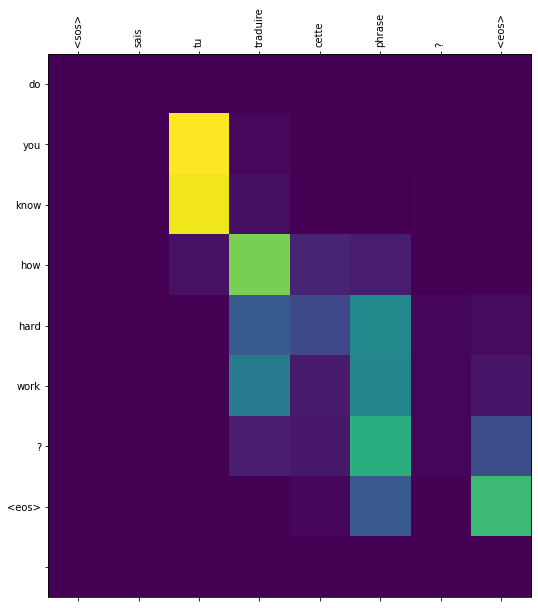

In [17]:
translate('sais-tu traduire cette phrase?')

Input:          <sos> vous pouvez expliquer encore une fois ? <eos>
Prediction:     can you hear anything like a time ? <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


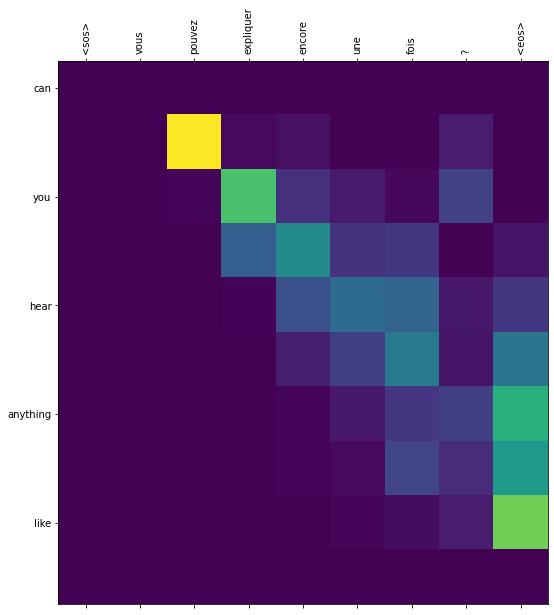

In [18]:
translate('Vous pouvez expliquer encore une fois?')

Input:          <sos> traduction automatique neuronale avec attention luong . <eos>
Prediction:     above a moat surrounds the world run over . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


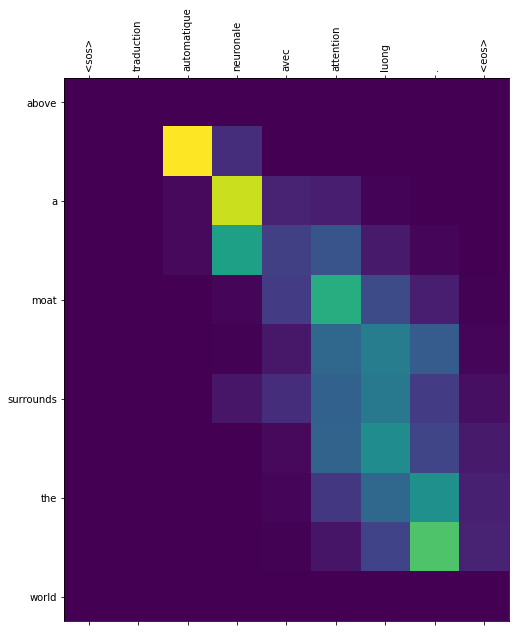

In [19]:
translate('Traduction automatique neuronale avec attention luong .')

# TODO

Their are few things to do to improve this model:

* implement an accuracy function so that we can have an idea how well the model is doing.

* the decoder output a probabilty for each word in the vocabilary (14410), this slow down training terribly. Instead, we can output a probability for a random sample of words (containing the correct word) using tf.nn.sampled_softmax_loss() function.

* Make a nice interface so that users can play with the model.

# References

* [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention)